# About

This notebook helps you to create your first solution and the first submisson file. Fill free to modify this notebook to create you own solution.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
from tqdm import tqdm
import seaborn as sns

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

In [2]:
# Change this according to your directory preferred setting
path_to_train = "data/train_1"
path_to_test = "data/test"

# This event is in Train_1
event_prefix = "event000001000"

### Train

Lets combine several events into single sample to train the classifier.

In [3]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

def get_training_sample(path_to_data, event_names):

    events = []
    track_id = 0

    for name in tqdm(event_names):
        # if there is an error skip it
        try:
            # Read an event
            hits, cells, particles, truth = load_event(os.path.join(path_to_data, name))

            # Generate new vector of particle id
            particle_ids = truth.particle_id.values
            particle2track = {}
            for pid in np.unique(particle_ids):
                particle2track[pid] = track_id
                track_id += 1
            hits['particle_id'] = [particle2track[pid] for pid in particle_ids]
            
            # get mean cell for each hit
            cells['ch0'] = cells.groupby("hit_id").transform("mean")['ch0']
            cells['ch1'] = cells.groupby("hit_id").transform("mean")['ch1']
            cells['value'] = cells.groupby("hit_id").transform("mean")['value']
            cells.drop_duplicates()
            
            # add cell info to hits
            hits['ch0'] = cells['ch0'].astype("int")
            hits['ch1'] = cells['ch1'].astype("int")
            hits['value'] = cells['value']

            # Collect hits
            events.append(hits)
        except:
            print("Error with", name)
            continue
            
    # Put all hits into one sample with unique track ids
    data = pd.concat(events, axis=0)

    return data

def get_test_sample(path_to_test, event_ids = ['000000000']):
    events = []
    for event_id in event_ids:
        hits  = pd.read_csv(path_to_test + '/event%s-hits.csv'%event_id)
        truth = pd.read_csv('%s.dbscan_outliers_tuned.csv.gz'%event_id, compression='gzip')
        
        hits['event_id'] = event_id
        hits['particle_id'] = truth.track_id
        
        events.append(hits)
    data = pd.concat(events, axis=0)
    return data

In [125]:
test_data = get_test_sample(path_to_test, event_ids = ['000000000', '000000001', '000000002','000000003','000000004'])

In [110]:
test_data = pd.read_csv("1000data.csv")

test_data['size'] = test_data.groupby('predictions')['predictions'].transform('count')
test_data.loc[test_data.predictions == 0, 'size'] = 1
test_data.loc[test_data['size'] > 20, 'size'] = 1
hit_count = test_data['size'].values

In [111]:
start_event_id = 1000
n_train_samples = 1
train_event_names = ["event0000{:05d}".format(i) for i in range(start_event_id, start_event_id+n_train_samples)]
train_data = get_training_sample(path_to_train, train_event_names)

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


In [112]:
train_data['size'] = train_data.groupby('particle_id')['particle_id'].transform('count')
train_data.loc[train_data.particle_id == 0, 'size'] = 1
train_data.loc[train_data['size'] > 20, 'size'] = 1
hit_count = train_data['size'].values

In [113]:
# test_data['size'] = test_data.groupby('particle_id')['particle_id'].transform('count')
# test_data.loc[test_data.particle_id == 0, 'size'] = 1
# test_data.loc[test_data['size'] > 20, 'size'] = 1
# hit_count = test_data['size'].values

In [114]:
test_data['size'] = test_data.groupby('predictions')['predictions'].transform('count')
test_data.loc[test_data.predictions == 0, 'size'] = 1
test_data.loc[test_data['size'] > 20, 'size'] = 1
hit_count = test_data['size'].values

In [115]:
#add some features
def add_features(train_data):
    train_data['r'] = np.sqrt(train_data['x'].values**2+train_data['y'].values**2+train_data['z'].values**2)
    train_data['rt'] = np.sqrt(train_data['x'].values**2+train_data['y'].values**2)
    train_data['x2'] = train_data['x'] / train_data['r']
    train_data['y2'] = train_data['y'] / train_data['r']
    train_data['z2'] = train_data['z'] / train_data['r']
    train_data['a0'] = np.arctan2(train_data['y'].values,train_data['x'].values)
    train_data['a1'] = train_data['a0']+1*(train_data['rt']+(1)*train_data['rt']**2)/1000*(1/2)/180*math.pi
    train_data['sina1'] = np.sin(train_data['a1'].values)
    train_data['cosa1'] = np.cos(train_data['a1'].values)
    
    return train_data

train_data = add_features(train_data)
test_data = add_features(test_data)

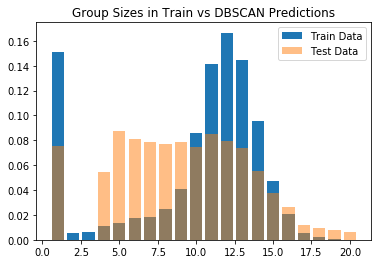

In [118]:
plt.bar(pd.value_counts(train_data['size'], normalize=True).sort_index().index, pd.value_counts(train_data['size'], normalize=True).sort_index().values, label="Train Data")
plt.bar(pd.value_counts(test_data['size'], normalize=True).sort_index().index, pd.value_counts(test_data['size'], normalize=True).sort_index().values, label="Test Data", alpha=0.5)
plt.title("Group Sizes in Train vs DBSCAN Predictions")
plt.legend()
plt.show()

In [119]:
one_submission = create_one_event_submission(event_id, hits, labels)

In [120]:
test_data = pd.read_csv("1000data.csv")

test_data['size'] = test_data.groupby('predictions')['predictions'].transform('count')
test_data.loc[test_data.predictions == 0, 'size'] = 1
test_data.loc[test_data['size'] > 20, 'size'] = 1
hit_count = test_data['size'].values

In [121]:
for event_id in test_data.event_id.unique():
    hits = test_data[test_data.event_id == event_id]
    labels = test_data[test_data.event_id == event_id].predictions
    one_submission = create_one_event_submission(event_id, hits, labels)
    truth = pd.read_csv("./data/train_1/event00000"+str(event_id)+"-truth.csv")
    break
score = score_event(truth, one_submission)
score    

0.5246370117396486

In [122]:
big_group_pids = hit_count[hit_count > 15]
big_group_filter = np.isin(train_data.particle_id, big_group_pids)
# big_groups = train_data[big_group_filter]
big_groups = train_data[train_data['size'] > 15]

small_group_pids = hit_count[hit_count <= 15]
small_group_filter = np.isin(train_data.particle_id, small_group_pids)
small_groups = train_data[train_data['size'] <= 15]

/home/skooch/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


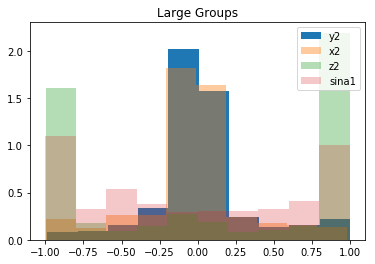

In [127]:
plt.hist(big_groups['y2'], label="y2", normed=True)
plt.hist(big_groups['x2'], label="x2", normed=True, alpha=0.4)
plt.hist(big_groups['z2'], label="z2", normed=True, alpha=0.35)
plt.hist(big_groups['sina1'], label="sina1", normed=True, alpha=0.25)
plt.legend()
plt.title("Large Groups")
plt.show()

/home/skooch/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


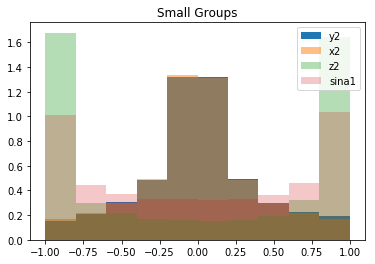

In [128]:
plt.hist(small_groups['y2'], label="y2", normed=True)
plt.hist(small_groups['x2'], label="x2", normed=True, alpha=0.5)
plt.hist(small_groups['z2'], label="z2", normed=True, alpha=0.35)
plt.hist(small_groups['sina1'], label="sina1", normed=True, alpha=0.25)
plt.title("Small Groups")
plt.legend()
plt.show()

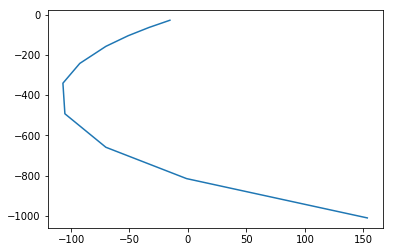

In [129]:
p_id = 49909    
p_id = 1110
p_id = 10
plt.plot(train_data[train_data.particle_id == p_id].sort_values("y").x, train_data[train_data.particle_id == p_id].sort_values("y").y)

In [131]:
test_data.sort_values("particle_id").head(30)

,Unnamed: 0,hit_id,x,y,z,volume_id,layer_id,module_id,ch0,ch1,...,a1,sina1,cosa1,s2,e2,N2,particle_id,predictions,event_id,size
0,0,1,-64.40990,-7.1637,-1502.500,7,2,1,209,617,...,-3.157234,0.015641,-0.999878,0,0.004052,1,0,19801843,1000,1
105860,105860,105861,648.44200,-501.1790,-2144.500,16,6,40,45,847,...,-2.215905,-0.799034,-0.601286,81671,0.004052,1,0,19804762,1000,9
80223,80223,80224,25.90540,-358.4830,-313.500,13,4,407,158,566,...,-2.192752,-0.812741,-0.582626,58716,0.004052,1,0,19801843,1000,1
105866,105866,105867,794.70600,-466.9570,-2155.500,16,6,41,279,1121,...,-2.277229,-0.760682,-0.649124,81676,0.004052,1,0,1351823,1000,5
105868,105868,105869,841.68200,-567.6180,-2155.500,16,6,41,260,1105,...,-2.510106,-0.590346,-0.807151,81678,0.004052,1,0,19803407,1000,4
105869,105869,105870,824.52200,-521.8720,-2155.500,16,6,41,101,1107,...,-2.409213,-0.668641,-0.743585,81677,0.004052,2,0,3694490,1000,9
46908,46908,46909,6.30192,-55.1245,597.500,9,2,31,226,560,...,-1.565224,-0.999984,0.005572,34577,0.004052,1,0,3714392,1000,11
105859,105859,105860,723.62600,-500.9750,-2144.500,16,6,40,45,847,...,-2.275101,-0.762062,-0.647504,81670,0.004052,1,0,19804443,1000,12
105872,105872,105873,833.98900,-345.5160,-2147.500,16,6,42,101,1107,...,-2.103869,-0.861250,-0.508182,81681,0.004052,2,0,19802901,1000,4
80217,80217,80218,-39.14670,-360.3230,-322.800,13,4,405,1,174,...,-2.378880,-0.690885,-0.722964,58711,0.004052,1,0,19801843,1000,1


In [93]:
train_data.sort_values("particle_id", ascending=False).head(30)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,size,r,rt,x2,y2,z2,a0,a1,sina1,cosa1
35216,35217,-5.883920,-71.851997,87.126503,8,4,264,50328,4,113.085617,72.092514,-0.052031,-0.635377,0.770447,-1.652503,-1.606519,-0.999362,-0.035715
50698,50699,-19.651199,-169.692993,159.625000,8,8,720,50328,4,233.799103,170.827057,-0.084052,-0.725807,0.682744,-1.686087,-1.429936,-0.990096,0.140395
50702,50703,-20.321400,-171.580002,161.085007,8,8,721,50328,4,236.222427,172.779205,-0.086027,-0.726349,0.681921,-1.688684,-1.426663,-0.989631,0.143635
43061,43062,-7.192760,-116.052002,119.677002,8,6,429,50328,4,166.860382,116.274689,-0.043106,-0.695504,0.717228,-1.632696,-1.513699,-0.998370,0.057067
35184,35185,-27.259300,-68.159798,125.028999,8,4,263,50327,8,144.986481,73.408630,-0.188013,-0.470111,0.862349,-1.951244,-1.903577,-0.945138,-0.326673
51668,51669,-62.209400,-159.380997,293.066010,8,8,873,50327,8,339.352325,171.091537,-0.183318,-0.469662,0.863604,-1.942929,-1.685987,-0.993373,-0.114936
96729,96730,-107.142998,-344.126007,620.200012,13,4,908,50327,8,717.321716,360.419678,-0.149365,-0.479737,0.864605,-1.872631,-0.735874,-0.671236,0.741244
35154,35155,-26.531300,-66.473900,121.871002,8,4,262,50327,8,141.333755,71.572960,-0.187721,-0.470333,0.862292,-1.950547,-1.905218,-0.944600,-0.328223
104523,104524,-120.846001,-486.584991,864.599976,13,6,1421,50327,8,999.450745,501.366821,-0.120912,-0.486852,0.865075,-1.814227,0.383754,0.374404,0.927266
135978,135979,-80.801598,-855.747986,1494.500000,18,4,24,50327,8,1724.054443,859.554260,-0.046867,-0.496358,0.866852,-1.664939,4.790101,-0.996982,0.077633


Pick some random samples from the train data and our predictions to compare.

In [141]:
train_idx = np.random.choice(train_data[(train_data.particle_id != 0) & (train_data['size'] > 1)].particle_id.unique(), size=50, replace=False)
test_idx = np.random.choice(test_data[(test_data.predictions != 0) & (test_data['size'] > 1)].predictions.unique(), size=50, replace=False)

train_filter = np.isin(train_data.particle_id, train_idx)
test_filter = np.isin(test_data.predictions, test_idx)

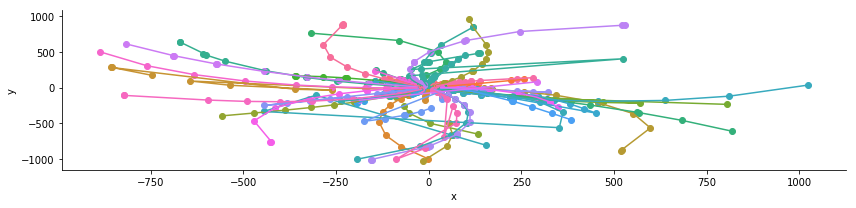

In [142]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x', 'y')
fg.map(plt.plot, 'x', 'y')

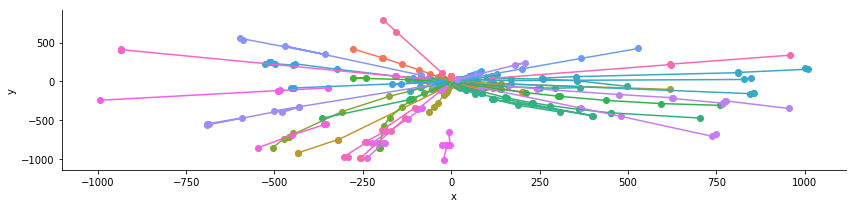

In [143]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x', 'y')
fg.map(plt.plot, 'x', 'y')

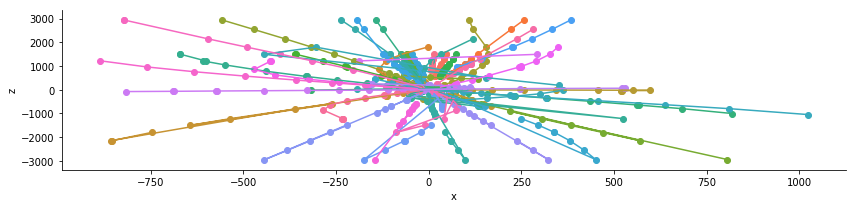

In [144]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x', 'z')
fg.map(plt.plot, 'x', 'z')

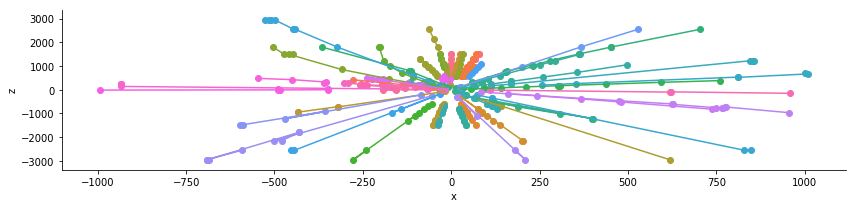

In [145]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x', 'z')
fg.map(plt.plot, 'x', 'z')

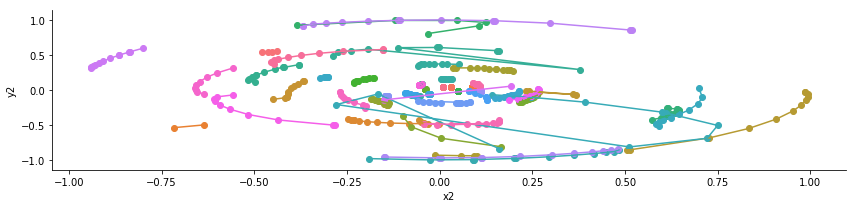

In [146]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'y2')
fg.map(plt.plot, 'x2', 'y2')

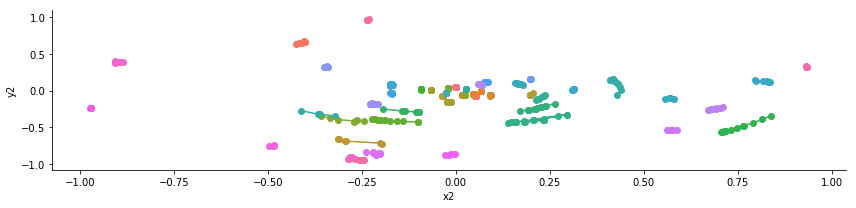

In [147]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x2', 'y2')
fg.map(plt.plot, 'x2', 'y2')

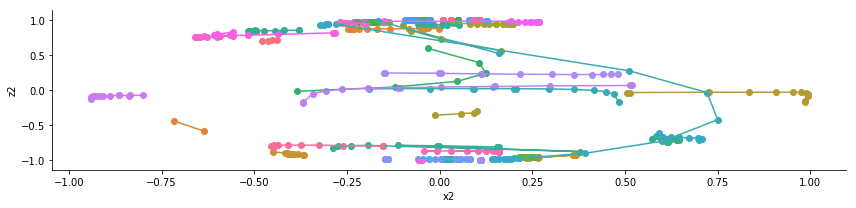

In [148]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'z2')
fg.map(plt.plot, 'x2', 'z2')

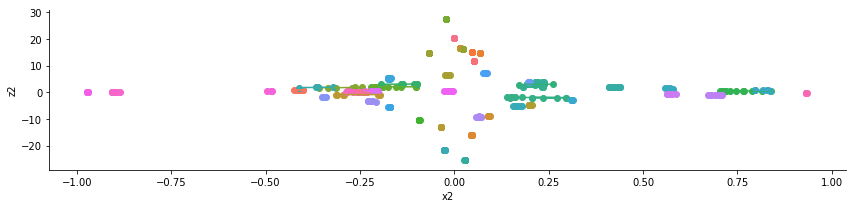

In [149]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x2', 'z2')
fg.map(plt.plot, 'x2', 'z2')

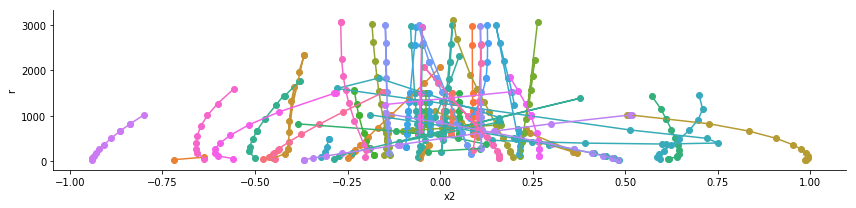

In [150]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'r')
fg.map(plt.plot, 'x2', 'r')

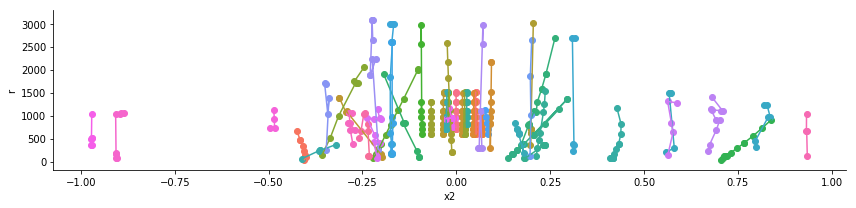

In [151]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x2', 'r')
fg.map(plt.plot, 'x2', 'r')

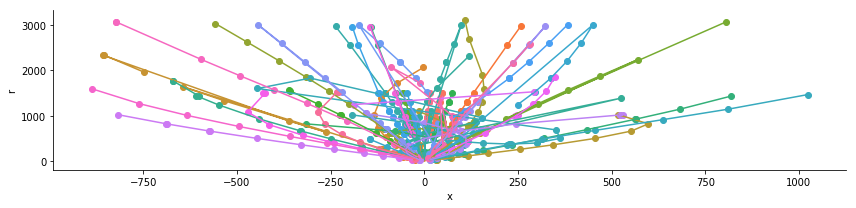

In [152]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x', 'r')
fg.map(plt.plot, 'x', 'r')

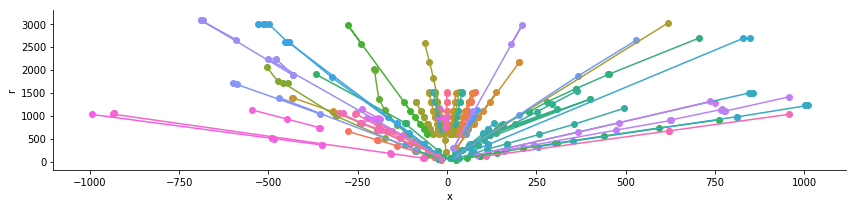

In [153]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x', 'r')
fg.map(plt.plot, 'x', 'r')

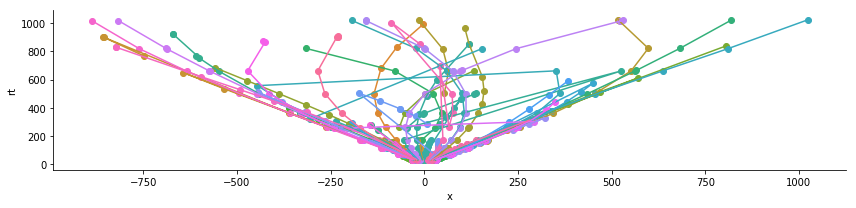

In [154]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x', 'rt')
fg.map(plt.plot, 'x', 'rt')

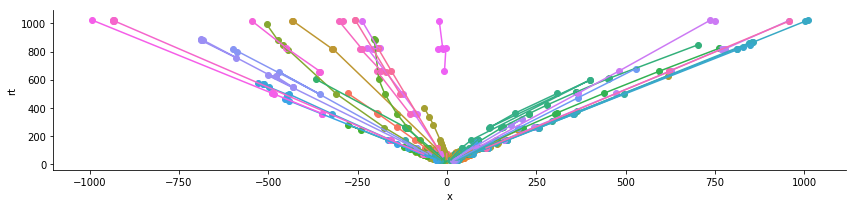

In [155]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x', 'rt')
fg.map(plt.plot, 'x', 'rt')

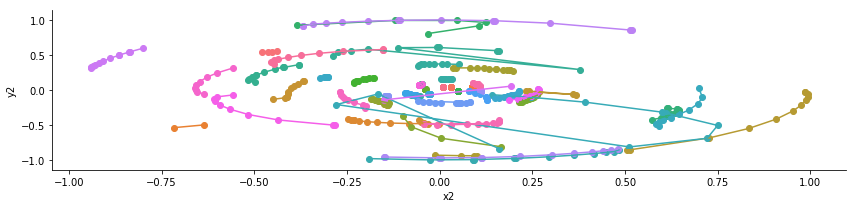

In [156]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'y2')
fg.map(plt.plot, 'x2', 'y2')

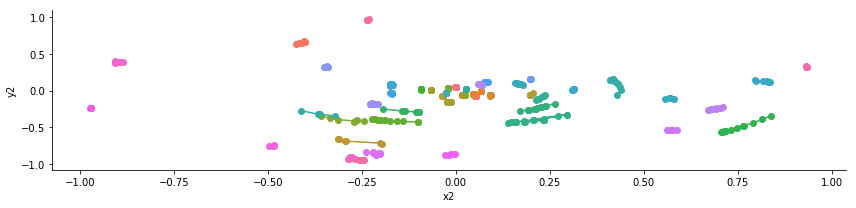

In [157]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x2', 'y2')
fg.map(plt.plot, 'x2', 'y2')

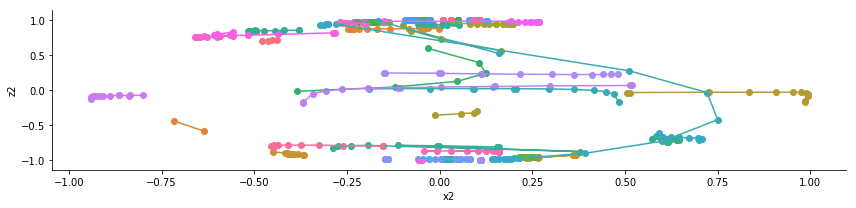

In [158]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'x2', 'z2')
fg.map(plt.plot, 'x2', 'z2')

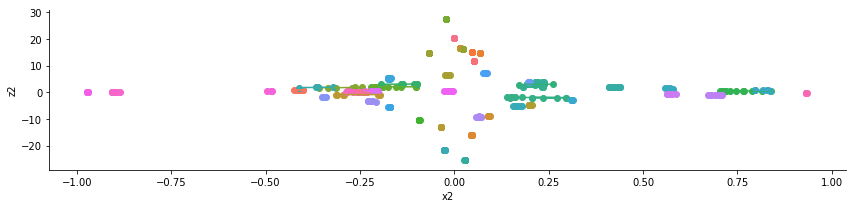

In [159]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'x2', 'z2')
fg.map(plt.plot, 'x2', 'z2')

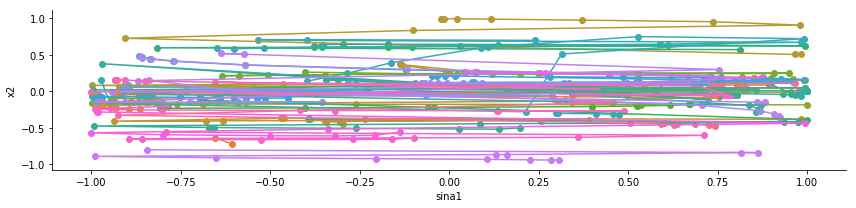

In [160]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'sina1', 'x2')
fg.map(plt.plot, 'sina1', 'x2')

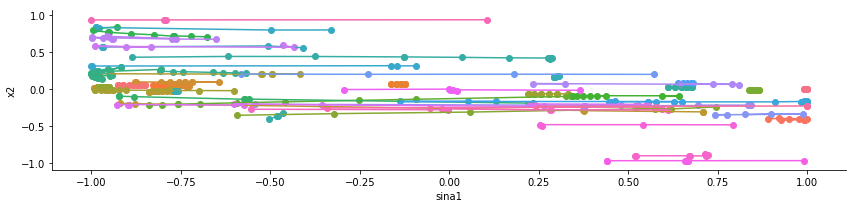

In [161]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'sina1', 'x2')
fg.map(plt.plot, 'sina1', 'x2')

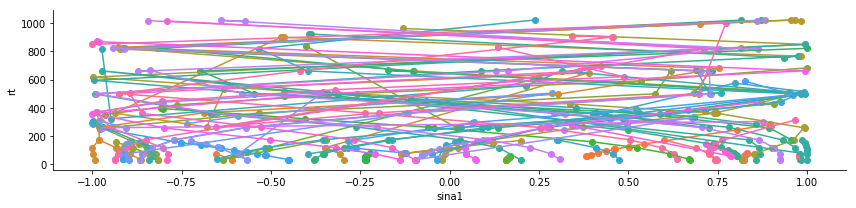

In [162]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'sina1', 'rt')
fg.map(plt.plot, 'sina1', 'rt')

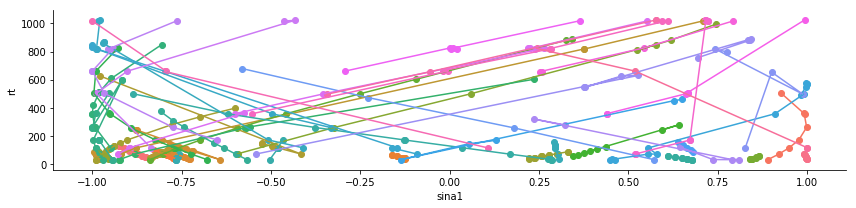

In [163]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'sina1', 'rt')
fg.map(plt.plot, 'sina1', 'rt')

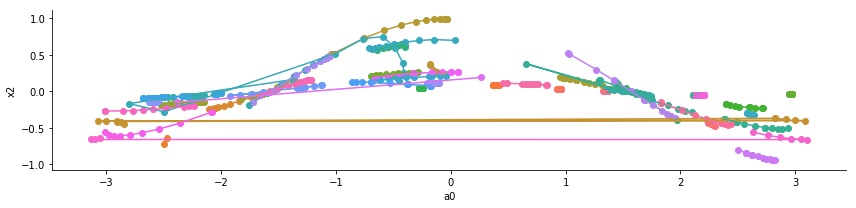

In [164]:
fg = sns.FacetGrid(data=train_data[train_filter], hue='particle_id', aspect=4)
fg.map(plt.scatter, 'a0', 'x2')
fg.map(plt.plot, 'a0', 'x2')

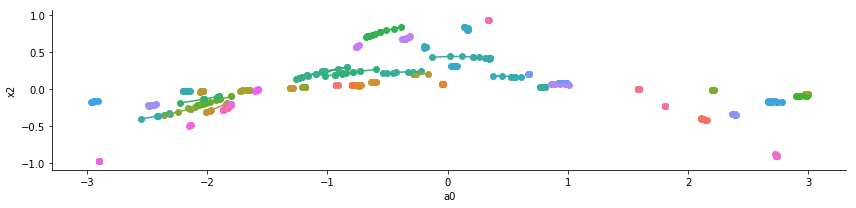

In [165]:
fg = sns.FacetGrid(data=test_data[test_filter], hue='predictions', aspect=4)
fg.map(plt.scatter, 'a0', 'x2')
fg.map(plt.plot, 'a0', 'x2')

Then, train the classifier using this sample. Notice that data preprocessing is included into the training procedure.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

class Clusterer(object):
    
    def __init__(self):
        self.classifier = None
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    def fit(self, hits):
        
        X = self._preprocess(hits)
        y = hits.particle_id.values
        
        self.classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
        self.classifier.fit(X, y)
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        labels = self.classifier.predict(X)
        
        return labels

In [7]:
model = Clusterer()
model.fit(train_data)

### Test

Use the trained classifier to predict labels of hits in a new event.

In [8]:
path_to_event = os.path.join(path_to_train, "event0000{:05d}".format(start_event_id + n_train_samples + 1))
hits, cells, particles, truth = load_event(path_to_event)

In [9]:
%%time
# Warning: it takes about 30s per one event
labels = model.predict(hits)

CPU times: user 23.4 s, sys: 10.6 ms, total: 23.4 s
Wall time: 19 s


# Score

Calculate quality of the track pattern recognition for one event.

In [10]:
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [11]:
print("Your score: ", score)

Your score:  0.09900948072230796


# Recognize tracks in all events of a dataset

In this example, the dataset is the whole training set. This may take a very long time. To run on only a subset, use

     load_dataset(path_to_train, skip=1000, nevents=5)

It will skip the first 1000 events, and select the next 5 ones.

**Warning:** it takes about 30s per one event

In [33]:
dataset_submissions = []
dataset_scores = []

for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=10, nevents=5):
        
    # Track pattern recognition
    labels = model.predict(hits)
        
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)
    
    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)
    
    print("Score for event %d: %.3f" % (event_id, score))
    
print('Mean score: %.3f' % (np.mean(dataset_scores)))

Score for event 1010: 0.065
Score for event 1011: 0.068
Score for event 1012: 0.065
Score for event 1013: 0.078
Score for event 1014: 0.086
Mean score: 0.073


# Submission

Create a submission file.

**Warning:** it takes about 30s per one event

In [ ]:
path_to_test = "data/test"
test_dataset_submissions = []

create_submission = True

if create_submission:
    for event_id, hits, cells in load_dataset(path_to_test, parts=['hits', 'cells']):

        # Track pattern recognition
        labels = model.predict(hits)

        # Prepare submission for an event
        one_submission = create_one_event_submission(event_id, hits, labels)
        test_dataset_submissions.append(one_submission)
        
        print('Event ID: ', event_id)

    # Create submission file
    submission = pd.concat(test_dataset_submissions, axis=0)
    submission.to_csv('20180626_submission_3.csv.gz', index=False, compression='gzip')

Event ID:  0
Event ID:  1
Event ID:  2
Event ID:  3
Event ID:  4
Event ID:  5
Event ID:  6
Event ID:  7
Event ID:  8
Event ID:  9
Event ID:  10
Event ID:  11
Event ID:  12
Event ID:  13
Event ID:  14
Event ID:  15
Event ID:  16
Event ID:  17
Event ID:  18
Event ID:  19
Event ID:  20
Event ID:  21
Event ID:  22
Event ID:  23
Event ID:  24
Event ID:  25
Event ID:  26
Event ID:  27
Event ID:  28
Event ID:  29
Event ID:  30
Event ID:  31
Event ID:  32
Event ID:  33
Event ID:  34
Event ID:  35
Event ID:  36
Event ID:  37
Event ID:  38
Event ID:  39
Event ID:  40
Event ID:  41
Event ID:  42
Event ID:  43
Event ID:  44
Event ID:  45
Event ID:  46
Event ID:  47
Event ID:  48
Event ID:  49
